In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import r2_score

In [4]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']


LR

JBF-3443 pair predict model


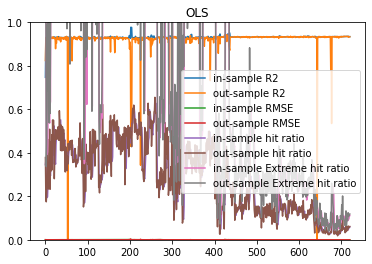

in-sample R2:  0.9319785491553917
out-sample R2:  0.9169925247577594
in-sample RMSE:  0.00018160790251455587
out-sample RMSE:  0.00019780035020754174
in-sample hit ratio:  0.27648953388183994
out-sample hit ratio:  0.283974706446047
in-sample Extreme hit ratio:  0.9203638848474502
out-sample Extreme hit ratio:  0.9321501319351939
QWF-2388 pair predict model


KeyboardInterrupt: 

In [5]:
for pair_idx in range(10): 
    futureCode = futureCodeList[pair_idx]
    stockCode = stockCodeList[pair_idx]
    print(futureCode + "-" + stockCode + " pair predict model")
    feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)
    corr_table = feature.corr()
    corr_table.style.background_gradient(cmap='coolwarm')

    feature.index = pd.to_datetime(feature.index)
    day_list = np.unique(feature.index.date)

    all_r2_in = []
    all_r2_out = []
    all_rmse_in = []
    all_rmse_out = []
    all_hit_ratio_in = []
    all_hit_ratio_out = []
    all_extreme_hit_rate_in = []
    all_extreme_hit_rate_out = []

    train_period = 3

    for i in range(len(day_list) - train_period):
        train_start_time = feature.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train = feature[train_start_time & train_end_time]
        test_start_time = feature.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test = feature[test_start_time & test_end_time]

        X_train = train[train.columns[0:-1]]
        X_test = test[test.columns[0:-1]]
        y_train = train['delta_spread']
        y_test = test['delta_spread']

        upper_quantile=0.85
        lower_quantile=0.15
        train_spread_upper = float(y_train.quantile(upper_quantile))
        train_spread_lower = float(y_train.quantile(lower_quantile))

        model_ols = LinearRegression()
        model_ols.fit(X_train, y_train)

        y_train_pred = model_ols.predict(X_train)
        y_test_pred = model_ols.predict(X_test)

        pred_ex_train_upper = y_train_pred > train_spread_upper
        pred_ex_train_lower = y_train_pred < train_spread_lower
        real_ex_train_upper = y_train > train_spread_upper
        real_ex_train_lower = y_train < train_spread_lower
        extreme_hit_rate_in = sum((pred_ex_train_upper | pred_ex_train_lower) & (real_ex_train_upper | real_ex_train_lower)) / (sum(pred_ex_train_upper) + sum(pred_ex_train_lower))

        pred_ex_test_upper = y_test_pred > train_spread_upper
        pred_ex_test_lower = y_test_pred < train_spread_lower
        real_ex_test_upper = y_test > train_spread_upper
        real_ex_test_lower = y_test < train_spread_lower
        extreme_hit_rate_out = sum((pred_ex_test_upper | pred_ex_test_lower) & (real_ex_test_upper | real_ex_test_lower)) / (sum(pred_ex_test_upper) + sum(pred_ex_test_lower))

        r2_in = model_ols.score(X_train, y_train)
        r2_out = model_ols.score(X_test, y_test)
        rmse_in = np.sqrt(np.mean((model_ols.predict(X_train) - y_train) ** 2))
        rmse_out = np.sqrt(np.mean((model_ols.predict(X_test) - y_test) ** 2))  

        hit_ratio_in = 0
        hit_ratio_out = 0
        for i in range(len(y_train_pred)):
            if y_train_pred[i] * y_train[i] > 0:
                hit_ratio_in += 1

        for i in range(len(y_test_pred)):
            if y_test_pred[i] * y_test[i] > 0:
                hit_ratio_out += 1

        all_r2_in.append(r2_in)
        all_r2_out.append(r2_out)
        all_rmse_in.append(rmse_in)
        all_rmse_out.append(rmse_out)
        all_hit_ratio_in.append(hit_ratio_in / len(y_train_pred))
        all_hit_ratio_out.append(hit_ratio_out / len(y_test_pred))
        all_extreme_hit_rate_in.append(extreme_hit_rate_in)
        all_extreme_hit_rate_out.append(extreme_hit_rate_out)

    plt.ylim((-0.5, 1.5))    
    plt.plot(all_r2_in, label='in-sample R2')
    plt.plot(all_r2_out, label='out-sample R2')
    plt.plot(all_rmse_in, label='in-sample RMSE')
    plt.plot(all_rmse_out, label='out-sample RMSE')
    plt.plot(all_hit_ratio_in, label='in-sample hit ratio')
    plt.plot(all_hit_ratio_out, label='out-sample hit ratio')
    plt.plot(all_extreme_hit_rate_in, label='in-sample Extreme hit ratio')
    plt.plot(all_extreme_hit_rate_out, label='out-sample Extreme hit ratio')
    plt.title('OLS')
    plt.legend()
    plt.show()

    print("in-sample R2: ", sum(all_r2_in) / len(all_r2_in))
    print("out-sample R2: ", sum(all_r2_out) / len(all_r2_out))
    print("in-sample RMSE: ", sum(all_rmse_in) / len(all_rmse_in))
    print("out-sample RMSE: ", sum(all_rmse_out) / len(all_rmse_out))
    print("in-sample hit ratio: ", sum(all_hit_ratio_in) / len(all_hit_ratio_in))
    print("out-sample hit ratio: ", sum(all_hit_ratio_out) / len(all_hit_ratio_out))
    print("in-sample Extreme hit ratio: ", sum(all_extreme_hit_rate_in) / len(all_extreme_hit_rate_in))
    print("out-sample Extreme hit ratio: ", sum(all_extreme_hit_rate_out) / len(all_extreme_hit_rate_out))
    print("========================================================================")


Tree

In [ ]:
for pair_idx in range(10): 
    futureCode = futureCodeList[pair_idx]
    stockCode = stockCodeList[pair_idx]
    print(futureCode + "-" + stockCode + " pair predict model")
    feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)
    corr_table = feature.corr()
    corr_table.style.background_gradient(cmap='coolwarm')

    feature.index = pd.to_datetime(feature.index)
    day_list = np.unique(feature.index.date)

    all_r2_in = []
    all_r2_out = []
    all_rmse_in = []
    all_rmse_out = []
    all_hit_ratio_in = []
    all_hit_ratio_out = []
    all_extreme_hit_rate_in = []
    all_extreme_hit_rate_out = []

    train_period = 3

    for i in range(len(day_list) - train_period):
        train_start_time = feature.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train = feature[train_start_time & train_end_time]
        test_start_time = feature.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test = feature[test_start_time & test_end_time]

        X_train = train[train.columns[0:-1]]
        X_test = test[test.columns[0:-1]]
        y_train = train['delta_spread']
        y_test = test['delta_spread']

        upper_quantile=0.85
        lower_quantile=0.15
        train_spread_upper = float(y_train.quantile(upper_quantile))
        train_spread_lower = float(y_train.quantile(lower_quantile))

        gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=50)
        gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)

        y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
        y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

        pred_ex_train_upper = y_train_pred > train_spread_upper
        pred_ex_train_lower = y_train_pred < train_spread_lower
        real_ex_train_upper = y_train > train_spread_upper
        real_ex_train_lower = y_train < train_spread_lower
        extreme_hit_rate_in = sum((pred_ex_train_upper | pred_ex_train_lower) & (real_ex_train_upper | real_ex_train_lower)) / (sum(pred_ex_train_upper) + sum(pred_ex_train_lower))

        pred_ex_test_upper = y_test_pred > train_spread_upper
        pred_ex_test_lower = y_test_pred < train_spread_lower
        real_ex_test_upper = y_test > train_spread_upper
        real_ex_test_lower = y_test < train_spread_lower
        extreme_hit_rate_out = sum((pred_ex_test_upper | pred_ex_test_lower) & (real_ex_test_upper | real_ex_test_lower)) / (sum(pred_ex_test_upper) + sum(pred_ex_test_lower))

        r2_in = r2_score(y_train, y_train_pred)
        r2_out = r2_score(y_test, y_test_pred)
        rmse_in = np.sqrt(np.mean((y_train_pred - y_train) ** 2))
        rmse_out = np.sqrt(np.mean((y_test_pred - y_test) ** 2)) 

        hit_ratio_in = 0
        hit_ratio_out = 0
        for i in range(len(y_train_pred)):
            if y_train_pred[i] * y_train[i] > 0:
                hit_ratio_in += 1

        for i in range(len(y_test_pred)):
            if y_test_pred[i] * y_test[i] > 0:
                hit_ratio_out += 1

        all_r2_in.append(r2_in)
        all_r2_out.append(r2_out)
        all_rmse_in.append(rmse_in)
        all_rmse_out.append(rmse_out)
        all_hit_ratio_in.append(hit_ratio_in / len(y_train_pred))
        all_hit_ratio_out.append(hit_ratio_out / len(y_test_pred))
        all_extreme_hit_rate_in.append(extreme_hit_rate_in)
        all_extreme_hit_rate_out.append(extreme_hit_rate_out)

    plt.ylim((-0.5, 1.5))  
    plt.plot(all_r2_in, label='in-sample R2')
    plt.plot(all_r2_out, label='out-sample R2')
    plt.plot(all_rmse_in, label='in-sample RMSE')
    plt.plot(all_rmse_out, label='out-sample RMSE')
    plt.plot(all_hit_ratio_in, label='in-sample hit ratio')
    plt.plot(all_hit_ratio_out, label='out-sample hit ratio')
    plt.plot(all_extreme_hit_rate_in, label='in-sample Extreme hit ratio')
    plt.plot(all_extreme_hit_rate_out, label='out-sample Extreme hit ratio')
    plt.title('LGBM')
    plt.legend()
    plt.show()

    print("in-sample R2: ", sum(all_r2_in) / len(all_r2_in))
    print("out-sample R2: ", sum(all_r2_out) / len(all_r2_out))
    print("in-sample RMSE: ", sum(all_rmse_in) / len(all_rmse_in))
    print("out-sample RMSE: ", sum(all_rmse_out) / len(all_rmse_out))
    print("in-sample hit ratio: ", sum(all_hit_ratio_in) / len(all_hit_ratio_in))
    print("out-sample hit ratio: ", sum(all_hit_ratio_out) / len(all_hit_ratio_out))
    print("in-sample Extreme hit ratio: ", sum(all_extreme_hit_rate_in) / len(all_extreme_hit_rate_in))
    print("out-sample Extreme hit ratio: ", sum(all_extreme_hit_rate_out) / len(all_extreme_hit_rate_out))
    print("========================================================================")
